## Decision making in low-rank recurrent neural networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
import torch.nn as nn

#plt.style.use('dark_background')

# For debugging we will use the below inside some functions.
torch.autograd.set_detect_anomaly(True)
        

### Perceptual decision makingg

__1. Create a function for generating the data.__

In [2]:
# defining standard deviation and strength of stimulus
std = 0.03
stim_strength = std * np.hstack((-np.flip(2**np.arange(0,5)), 2**np.arange(0,5)))


In [3]:
# TODO: check the dimensions needed for the target y.


def generate_data(time_length, trials, stim_strength, std = 0.03):
    """
    ksi is a normally distr noise with sigma 0.03.
    u is an input
    û is the stimulis strength
    y is the target, i.e. the sign of û. 
    y's first dimension is time length and second is  trials. 
    """
    ksi = std * np.random.randn(time_length, trials)
    
  
    û_value = np.random.choice(stim_strength, size=trials)
    û = np.full_like(ksi, 0)
    y = np.full_like(ksi, 1)
    for i in range(trials):  # vectorize it??
        û[5:46, i] = û_value[i]
        y[:, i] = np.sign(û_value[i]) * y[:, i]
    
    return  torch.from_numpy(û + ksi).reshape([time_length, trials, 1, 1]), torch.from_numpy(y)


In [4]:
# generate data

T = 75
trials = 8
u, y = generate_data(T, trials, stim_strength)
time = np.arange(0,T)


In [5]:
u.shape, y.shape

(torch.Size([75, 8, 1, 1]), torch.Size([75, 8]))

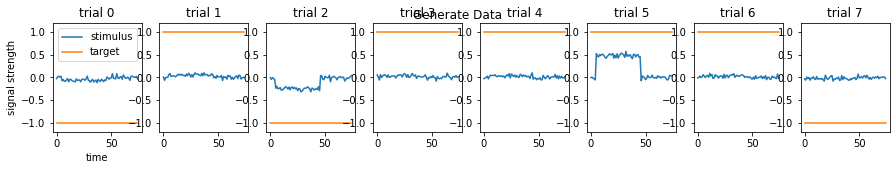

In [6]:
# plot

fig, axs = plt.subplots(1, trials, figsize=(15,2))

fig.suptitle("Generate Data")

for i in range(trials):
    axs[i].plot(time, u[:, i, 0, 0], label="stimulus")
    axs[i].plot(time, y[:, i], label="target")
    axs[i].set_title(f"trial {i}")
    axs[i].set_ylim(-1.2, 1.2)
axs[0].set_xlabel("time")
axs[0].set_ylabel("signal strength")
axs[0].legend()
plt.show()

__2. Implement the recurrent neural network in your favorite deep learning library.__

J matrix has to have two trainable vectors m, and n as parameters.

In [7]:
# TODO: vectorize input and targets and all into batch of time and trials.

In [15]:
#Todo: finish refactoring for batch dim, reduce the reshapings.

def dynamics(x, u_of_t, tau, m,n,I):
    J_of_phi_x = torch.div(torch.matmul(torch.matmul(m, n).float(), torch.tanh(x).float()), len(n))

    return (-x + J_of_phi_x + u_of_t*I) / tau  # is broadcasting working for input and in weigths?


In [25]:
# Test dynamics.
x = torch.randn([2,124,1])   # trials, size of the network, and 1 dimension
I = torch.randn([124,1])   # size of the network and 1 dimension

u, y = generate_data(74, 2, stim_strength) # time, trials, stimulis strength
tau = 0.1




m = torch.randn(2, 124, 1)
n = torch.randn(2, 1, 124)
(u[50]*I).shape, dynamics(x, u[50], tau, m, n, I).shape


(torch.Size([2, 124, 1]), torch.Size([2, 124, 1]))

In [26]:

class LR_RNN(nn.Module):
    # Low-rank recurrent neural network without readout.
    def __init__(self, N):
        super().__init__()
        # storign info
        self.N = N
        
        # pattern from witch connectivity is made
        tensor_m = torch.randn([N,1])
        self.m = nn.Parameter(tensor_m)
        
        # pattern to which connectivity is made
        tensor_n = torch.randn([1,N])
        self.n = nn.Parameter(tensor_n)
        
        # input weights
        self.I = torch.randn([N,1])
        
        # Output is defined separetly in different class below.

          
    def forward(self, x, u_of_t, tau, dt):
        # It's an Euler method.
        return x +  dt * dynamics(x, u_of_t, tau, self.m, self.n, self.I)
   

In [57]:
class Model(nn.Module):
    def __init__(self, trials, N):
        super().__init__()
        # storing info
        self.N = N
        
        # the layer
        self.lr_rnn = LR_RNN(N)
        
        # output layer
        std_dev = 4
        self.w = std_dev*torch.randn([1, N])
        

    
    def forward(self, x: torch.Tensor, u_of_t, tau, dt):
        
        """
        Going forward with the low rank rnn and input.
        Reading through electrode weights.
        """
        x1 = self.lr_rnn(x, u_of_t, tau, dt)

        torch.autograd.set_detect_anomaly(True)
        
        z = 1/self.N * torch.matmul(self.w.float(), torch.tanh(x1).float())
        z.squeeze_()
        return x1, z
        

In [58]:

a_trials = 2
a_model = Model(a_trials, 512)
a_T = 74
a_u, a_y = generate_data(a_T, a_trials, stim_strength)
a_x = torch.zeros([a_trials,512,1])

a_tau = 0.1
a_dt = 0.02
a_x, a_z = a_model(a_x, a_u[50], a_tau, a_dt)
a_u.shape, a_x.shape, a_z.shape

(torch.Size([74, 2, 1, 1]), torch.Size([2, 512, 1]), torch.Size([2]))

In [29]:
# TODO: check dimensions for multiplication self.w with tanh(x)

In [59]:
# Initialize.

N = 124
trials = 32    # Mini-batch size, minimum value is 2 (probably because of squeezing and broadcasting).
model = Model(trials, N)
x = torch.zeros([trials,N,1])

tau = 0.1  # seconds
dt = 0.02  # seconds


In [60]:
# Generate the data.

T = 75
read_onset = 13  # how many last steps are read
time = np.arange(0,T)
u, y = generate_data(T, trials, stim_strength)

In [68]:
"""
Training:

From the readout onset the network is unrolled 

and the backpropagation goes back in time until the beginning of the readout.

Backprop is called after computing the error on the whole batch.


"""

epochs = 200

mse_loss = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
loss_record = []

for epoch in range(epochs):

        target = torch.zeros([read_onset, trials])
        x = [None]*(read_onset+1)
        x[0] = torch.zeros([trials, model.N, 1])
        losses = torch.zeros(read_onset)

        for t in range(T-read_onset):

            x[0] = model.lr_rnn.forward(x[0], u[t], tau, dt)
            

        x[0].detach_()
        
        
        
        for k in range(read_onset-1):

            # Initializations.
            t = T - read_onset + k        
            
            
            # Computation and storage of the results.                
            x[k+1], z = model.forward(x[k], u[t], tau, dt)
            z_squeezed = z.squeeze()

            
            # use the error or mse.
            losses[k+1] = mse_loss(z_squeezed, y[t+1, :].float())
            
            # TODO: sum and store loss through time
            
            
            
            
            
        optimizer.zero_grad()  # Reset the gradient values.
        torch.autograd.set_detect_anomaly(True)
 
        loss = torch.sum(losses)
        losses[-1].backward()  # Compute the gradients.

        optimizer.step()  # Parameters update.
            
        
        loss_record.append(loss.detach())    
        #if epoch%10 == 0:
        
        print("  ", epoch,"/",epochs, "epoch mean error is  ------------  ", loss)
        
        

   0 / 200 epoch mean error is  ------------   tensor(12.0158, grad_fn=<SumBackward0>)
   1 / 200 epoch mean error is  ------------   tensor(12.0109, grad_fn=<SumBackward0>)
   2 / 200 epoch mean error is  ------------   tensor(12.0075, grad_fn=<SumBackward0>)
   3 / 200 epoch mean error is  ------------   tensor(12.0048, grad_fn=<SumBackward0>)
   4 / 200 epoch mean error is  ------------   tensor(12.0027, grad_fn=<SumBackward0>)
   5 / 200 epoch mean error is  ------------   tensor(12.0009, grad_fn=<SumBackward0>)
   6 / 200 epoch mean error is  ------------   tensor(11.9994, grad_fn=<SumBackward0>)
   7 / 200 epoch mean error is  ------------   tensor(11.9981, grad_fn=<SumBackward0>)
   8 / 200 epoch mean error is  ------------   tensor(11.9969, grad_fn=<SumBackward0>)
   9 / 200 epoch mean error is  ------------   tensor(11.9958, grad_fn=<SumBackward0>)
   10 / 200 epoch mean error is  ------------   tensor(11.9947, grad_fn=<SumBackward0>)
   11 / 200 epoch mean error is  ---------

   94 / 200 epoch mean error is  ------------   tensor(11.9847, grad_fn=<SumBackward0>)
   95 / 200 epoch mean error is  ------------   tensor(11.9810, grad_fn=<SumBackward0>)
   96 / 200 epoch mean error is  ------------   tensor(11.9763, grad_fn=<SumBackward0>)
   97 / 200 epoch mean error is  ------------   tensor(11.2383, grad_fn=<SumBackward0>)
   98 / 200 epoch mean error is  ------------   tensor(11.2385, grad_fn=<SumBackward0>)
   99 / 200 epoch mean error is  ------------   tensor(10.8792, grad_fn=<SumBackward0>)
   100 / 200 epoch mean error is  ------------   tensor(10.5216, grad_fn=<SumBackward0>)
   101 / 200 epoch mean error is  ------------   tensor(10.5232, grad_fn=<SumBackward0>)
   102 / 200 epoch mean error is  ------------   tensor(10.5231, grad_fn=<SumBackward0>)
   103 / 200 epoch mean error is  ------------   tensor(10.5213, grad_fn=<SumBackward0>)
   104 / 200 epoch mean error is  ------------   tensor(10.5182, grad_fn=<SumBackward0>)
   105 / 200 epoch mean err

KeyboardInterrupt: 

In [ ]:
batch_loss, loss_sum
np.sum(loss_record[-16:-1])/15

Why $x$ should be set to zero after each trial?

In [ ]:
for parameter in model.parameters():
    print(parameter.size())

In [ ]:
# Playground sketch.

abatch = 11

am = torch.randn([N,1])
an = torch.randn([1,N])
aT = 77
#torch.matmul(torch.matmul(am,an), torch.tanh(ax)).shape, 

ax = torch.randn([abatch, N, 1])
au = torch.randn([aT, abatch, 1, 1])

aw = torch.randn([1, N])
aI = torch.randn([N,1])

au, ay = generate_data(abatch, aT, stim_strength)

(ax+au[61]*aI).shape

z = 1/N * torch.matmul(aw, torch.tanh(ax))
z.squeeze_().shape, ay[:,72].shape
